In [45]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import spotipy #https://spotipy.readthedocs.io/en/2.22.1/
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import statsmodels.api as sm #https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

## 1. Conexión con la API

In [ ]:
#Cargamos las credenciales
load_dotenv("keys.env")
client_id=os.environ.get("CLIENT_ID")
client_secret=os.environ.get("CLIENT_SECRET")

In [ ]:
#Realizamos la conexión con la API y cargamos las canciones mas destacadas
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
spotify = spotipy.Spotify(auth_manager=auth_manager)
top_songs=spotify.artist_top_tracks("5Uox3n7m4W2CoM9MmHPJwQ")
#Vemos las keys del diccionario
top_songs["tracks"][0].keys()

dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'is_playable', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri'])

El metodo artist_top_tracks nos devuelve un json que contiene informacion sobre las 10 mejores canciones del artista y está organizado de la siguiente forma:

- "tracks":
    
    *album*:

        'album_type', 'artists', 'available_markets', 'external_urls', 'href', 'id', 'images', 'is_playable', 'name', 'release_date', 'release_date_precision', 'total_tracks', 'type', 'uri'
    
    *artist*: 
    
        'external_urls', 'href', 'id', 'name', 'type', 'uri'
        
    *available_markets*: mercados en los que está disponible la canción

    *disc_number*: numero del disco

    *duration_ms*: duracion de la cancion en milisegundos (segundos/1000)

    *explicit*: contenido explicito

    *external_urls*: url de la cancion

    *name*: nombre de la cancion

    *popularity*: indice de popularidad (0-100)

    *track_number*: orden de aparicion en el album


## 2. Tratamiento de datos

Pasaremos la siguiente información relevante a un df: 

- Columnas album

     - nombre_album
     - fecha_album

- Columnas artistas

     - artista_1
     - artista_2
     - artista_3

- Columna duracion (milisegundos)

- Columna lenguaje explicito

- Columna nombre de la cancion

- Columna popularity (0-100, como de popular es la cancion con respecto a otras de la plataforma)


In [121]:
#Creamos un diccionario limpio con los datos objetivos
info={"cancion": [],
      "duracion_min": [],
      "duracion_seg": [],
      "popularidad": [],
      "artista_1": [],
      "artista_2": [], 
      "artista_3": [],
      "explicito": [],
      "nombre_album": [],
      "fecha_album": []}

#Recorremos el diccionario de origen
for canc in range(len(top_songs["tracks"])):
      #Cancion
      info["cancion"].append(top_songs["tracks"][canc]["name"])
      #Duracion
      ##Minutos
      min=round(top_songs["tracks"][canc]["duration_ms"]/1000/60,2)
      info["duracion_min"].append(min)
      ##Segundos
      seg=round(top_songs["tracks"][canc]["duration_ms"]/1000,2)
      info["duracion_seg"].append(seg)
      #Popularidad
      info["popularidad"].append(top_songs["tracks"][canc]["popularity"])
      
      #Artistas
      artistas = top_songs["tracks"][canc]["artists"]
      
      # Añadir primer artista (siempre existe)
      info["artista_1"].append(artistas[0]["name"])
      
      # Añadir segundo artista si existe, si no "NaN"
      info["artista_2"].append(artistas[1]["name"] if len(artistas) > 1 else "NaN")
      
      # Añadir tercer artista si existe, si no "NaN"
      info["artista_3"].append(artistas[2]["name"] if len(artistas) > 2 else "NaN")

      #Explicito
      info["explicito"].append(top_songs["tracks"][canc]["explicit"])
      #Album
      info["nombre_album"].append(top_songs["tracks"][canc]["album"]["name"])
      info["fecha_album"].append(top_songs["tracks"][canc]["album"]["release_date"])

#Creamos un df con los resultados:
data=pd.DataFrame(info)

In [122]:
data

cancion  duracion_min  duracion_seg  popularidad     artista_1  \
0         Still Luvin          4.12        246.97           72      Delaossa   
1            El Patio          3.88        232.65           67  Pepe y Vizio   
2              Veneno          4.31        258.59           64      Delaossa   
3               Lejos          3.38        202.58           59      Delaossa   
4          La Placita          3.80        228.29           58      Delaossa   
5              Flores          3.15        188.86           58      Delaossa   
6        Nueva Season          3.79        227.50           55      Delaossa   
7         Ojos Verdes          3.18        190.59           56      Delaossa   
8  Demonios De Blanco          3.30        198.11           55      Delaossa   
9           2 The Sky          2.47        148.00           56      Delaossa   

     artista_2      artista_3  explicito    nombre_album fecha_album  
0      Quevedo  Bigla The Kid      False      La Madrugá  2025-03-20  
1     Delaossa          KIDDO      False        El Patio  2022-07-15  
2        KIDDO        J.Moods      False  La Tour Liffee  2020-06-04  
3  Cruz Cafuné      Gese Da O      False           Lejos  2020-03-24  
4      EAZYBOI        J.Moods      False      La Placita  2019-07-19  
5          NaN            NaN      False          Flores  2025-09-17  
6          NaN            NaN       True      La Madrugá  2025-03-20  
7          NaN            NaN      False     Ojos Verdes  2021-09-29  
8   Recycled J            NaN      False      La Madrugá  2025-03-20  
9          NaN            NaN       True      La Madrugá  2025-03-20

## 3. Relación Popularidad-Duracion

El indice de popularidad mide cuan popular es una canción frente a otras con características similares, tomando valores desde 0 (poco popular) a 100 (muy popular).

Fuente: https://www.submithub.com/story/spotify-popularity-score-guide

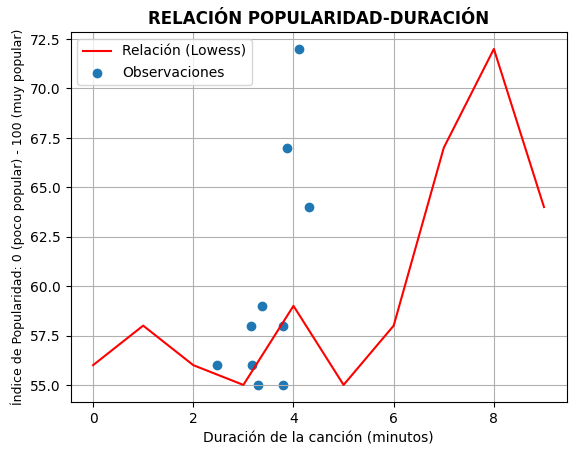

In [83]:
lowess=sm.nonparametric.lowess
y=lowess(data["popularidad"], data["duracion_min"], frac=1/10)

plt.plot(y[:,1], color="r", label="Relación (Lowess)")
plt.scatter(data["duracion_min"], data["popularidad"], label="Observaciones")
plt.title("Relación Popularidad-Duración".upper(), fontweight="bold")
plt.xlabel("Duración de la canción (minutos)")
plt.ylabel("Índice de Popularidad: 0 (poco popular) - 100 (muy popular)", size=9)
plt.legend()
plt.grid()
plt.show()